# Analysing Insurance Claim Data

##### Exercise Brief
I have been provided with a dataset containing insurance claims information for a company.  
I have assumed that the dataset reflects claims on Accident & Health policies.
The dataset includes the following columns:
* __broker name__: The company who the risk was brokered by.
* __age__: Age of the insured.
* __sex__: The gender of the insured.
* __bmi__: The bmi score of the insured at policy inception.
* __children__: The number of children the insured had at policy inception.
* __smoker__: Whether the insured has smoked for an extended period of time.
* __region__: Location of the insured.
* __claims incurred__: The total cost (GBP) of claims incurred by the insured.

##### The Task
1. Load the data, carry out EDA and __describe__ key statistics and insights gained from the data.
2. Check the dataset for missing values, duplicates and inconsistencies. Outline my approach to handle these effectively.
3. Create visualisations to help better understand the distribution of claims expenses. Interpret the visualisations and __make recommendations__ for the company based on the findings.

## Importing Modules & Loading Dataset

In [1282]:
# Begin by importing modules that I will most likely be using.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1283]:
# Create a dataframe using the csv that was provided.
df = pd.read_csv('MissionUK_ExampleDataSet.csv')

## Data Cleaning & EDA

In [1284]:
# There are 1340 rows of data and 8 columns in this dataframe.
df.shape

(1340, 8)

In [1285]:
# The first 15 rows of data.
df.head(15)

,broker name,age,sex,bmi,children,smoker,region,claims incurred
0,Broker D,18,male,53.13,0.0,no,southeast,1163.46270
1,Broker A,22,male,52.58,1.0,yes,southeast,44501.39820
2,Broker B,23,male,50.38,1.0,no,southeast,2438.05520
3,Broker A,58,male,49.06,0.0,no,southeast,11381.32540
4,Broker C,46,female,48.07,2.0,no,northeast,9432.92530
5,Broker B,52,male,47.74,1.0,no,southeast,9748.91060
6,Broker C,37,female,47.60,2.0,yes,southwest,46113.51100
7,Broker A,47,male,47.52,1.0,no,southeast,8083.91980
8,Broker C,54,female,47.41,0.0,yes,southeast,63770.42801
9,Broker D,52,female,46.75,5.0,no,southeast,12592.53450


In [1286]:
# It's not best practice to have headers that contain whitespace. I will change the header names.
df.rename(columns={'broker name': 'broker_name', 'claims incurred': 'claims_incurred'}, inplace=True)
df.head()

,broker_name,age,sex,bmi,children,smoker,region,claims_incurred
0,Broker D,18,male,53.13,0.0,no,southeast,1163.4627
1,Broker A,22,male,52.58,1.0,yes,southeast,44501.3982
2,Broker B,23,male,50.38,1.0,no,southeast,2438.0552
3,Broker A,58,male,49.06,0.0,no,southeast,11381.3254
4,Broker C,46,female,48.07,2.0,no,northeast,9432.9253


In [1287]:
# Let's look at nulls.
df.isnull().sum()
# There are not many nulls in the data but we cannot proceed without handling them.
# Will look at where they occur in the dataframe.

broker_name        1
age                1
sex                3
bmi                2
children           2
smoker             2
region             2
claims_incurred    1
dtype: int64

In [1288]:
df[df.isnull().any(axis=1)]
# There are 3 rows in the entire dataframe that contain nulls.
# Row 13 and row 663 are mostly, if not all nulls. We wouldn't lose much by dropping these rows.
# Row 655 is only missing sex. Will see if we can predict sex instead of dropping this row.

,broker_name,age,sex,bmi,children,smoker,region,claims_incurred
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
655,Broker D,35,NaN,30.5,1.0,no,southwest,4751.07000
663,Broker D,31,NaN,NaN,NaN,NaN,NaN,6113.23105


In [1289]:
# Will drop rows 13 and 663.
df.drop([df.index[13],df.index[663]],inplace=True)
df[df.isnull().any(axis=1)]
# One null row left to handle. I would like to see if we can use the data to help us predict sex.
# Let's dive into some machine learning!

,broker_name,age,sex,bmi,children,smoker,region,claims_incurred
655,Broker D,35,NaN,30.5,1.0,no,southwest,4751.07


## Predicting sex using Machine Learning

In [1290]:
# One hot encoding makes the world go around.
ohe = df.copy()
ohe = pd.get_dummies(ohe, columns = ['broker_name','region'])
ohe['sex'].replace('male',0,inplace=True)
ohe['sex'].replace('female',1,inplace=True)
ohe['sex'] = ohe['sex'].astype(bool)
ohe['smoker'].replace('no',0,inplace=True)
ohe['smoker'].replace('yes',1,inplace=True)
ohe['smoker'] = ohe['smoker'].astype(bool)

# I came into this problem while fitting the regression model a bit further up.
# I'll deal with it now here and go over it again a bit later.
ohe['age'].replace('Nineteen',19, inplace=True)
ohe['age'] = ohe['age'].astype(int)

In [1291]:
# Our test data.
test_data = ohe

# Separate the row from the dataframe and put it into a new variable.
test_data = test_data.loc[655:655]
test_data

,age,sex,bmi,children,smoker,claims_incurred,broker_name_Broker A,broker_name_Broker B,broker_name_Broker C,broker_name_Broker D,region_northeast,region_northwest,region_southeast,region_southwest
655,35,True,30.5,1.0,False,4751.07,0,0,0,1,0,0,0,1


In [1292]:
# Create a train dataframe and remove the offending row.
train_data = ohe
train_data.drop([655],inplace=True)

In [1293]:
try:
    train_data.loc[655]
except:
    print('Row no longer exists')

Row no longer exists


In [1294]:
# Create x_train and y_train.
x_train = train_data.drop('sex',axis=1)
y_train = train_data['sex']

In [1295]:
# Import Linear Regression module.
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [1296]:
# Fit on x_train and y_train.
lr.fit(x_train,y_train)

LinearRegression()

In [1297]:
# Drop the sex column from our testing data as it would be cheating to keep it otherwise.
x_test = test_data.drop('sex',axis=1)

In [1298]:
# Let's predict what the sex should be.
y_pred = lr.predict(x_test)
y_pred
# Well it seems that our model wasn't able to be certain on sex, it could really swing either way.
# I guess the silver lining is that it likely doesn't have a huge impact.

array([0.48706299])

In [1299]:
# I assigned male as our value slightly leaned towards male.
df['sex'].loc[655] = 'male'
df.loc[655]

/var/folders/0m/stgl1pf9481f3my39lrjf2vc0000gq/T/ipykernel_11830/811844874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'].loc[655] = 'male'


broker_name         Broker D
age                       35
sex                     male
bmi                     30.5
children                 1.0
smoker                    no
region             southwest
claims_incurred      4751.07
Name: 655, dtype: object

In [1300]:
# And we have no more nulls!
df.isnull().sum()

broker_name        0
age                0
sex                0
bmi                0
children           0
smoker             0
region             0
claims_incurred    0
dtype: int64

## Data Cleaning continued

In [1301]:
# Broker name column.
df['broker_name'] = df['broker_name'].astype(str)
df['broker_name'].value_counts()
# Nothing needs to be cleaned under this column. Will change to string type.

Broker A    345
Broker B    345
Broker D    328
Broker C    320
Name: broker_name, dtype: int64

In [1302]:
# Age column.
df['age'].value_counts()
# There is someone aged 295, likely a typo. Will see if we can use ML to give us a better estimate, or use median. 
# There is a typed out 'Nineteen' which we will rewrite numerically.

18          69
19          67
48          29
46          29
52          29
47          29
51          29
20          29
45          29
50          29
53          28
49          28
22          28
24          28
21          28
25          28
27          28
26          28
54          28
28          28
23          28
30          27
43          27
44          27
41          27
29          27
40          27
42          27
31          26
55          26
34          26
57          26
56          26
33          26
32          26
39          25
59          25
58          25
38          25
37          25
35          25
36          25
63          23
62          23
61          23
60          23
64          22
295          1
Nineteen     1
Name: age, dtype: int64

In [1303]:
# Let's fix that 'Nineteen'.
df['age'].replace('Nineteen',19, inplace=True)
df['age'] = df['age'].astype(int)
df['age'].value_counts()
# Now to fix that 295. We shall dive into machine learning again.

18     69
19     68
48     29
46     29
52     29
47     29
51     29
20     29
45     29
50     29
53     28
49     28
22     28
24     28
21     28
25     28
27     28
26     28
54     28
28     28
23     28
30     27
43     27
44     27
41     27
29     27
40     27
42     27
31     26
55     26
34     26
56     26
33     26
57     26
32     26
35     25
39     25
59     25
58     25
38     25
37     25
36     25
63     23
62     23
61     23
60     23
64     22
295     1
Name: age, dtype: int64

## Predicting age using Machine Learning

In [1304]:
# First let's find the offending row.
df.loc[df['age']==295]

,broker_name,age,sex,bmi,children,smoker,region,claims_incurred
293,Broker C,295,female,39.6,0.0,yes,northwest,29260.0


In [1305]:
# One hot encoding makes the world go around. Again.
ohe = df.copy()
ohe = pd.get_dummies(ohe, columns = ['broker_name','region'])
ohe['sex'].replace('male',0,inplace=True)
ohe['sex'].replace('female',1,inplace=True)
ohe['sex'] = ohe['sex'].astype(bool)
ohe['smoker'].replace('no',0,inplace=True)
ohe['smoker'].replace('yes',1,inplace=True)
ohe['smoker'] = ohe['smoker'].astype(bool)

In [1306]:
# Our test data.
test_data = ohe

# Separate the row from the dataframe and put it into a new variable.
test_data = test_data.loc[test_data['age']==295]
test_data

,age,sex,bmi,children,smoker,claims_incurred,broker_name_Broker A,broker_name_Broker B,broker_name_Broker C,broker_name_Broker D,region_northeast,region_northwest,region_southeast,region_southwest
293,295,True,39.6,0.0,True,29260.0,0,0,1,0,0,1,0,0


In [1307]:
# Create a train dataframe and remove the offending row.
train_data = ohe
train_data.drop(293,inplace=True)
train_data.loc[train_data['age']==295]

,age,sex,bmi,children,smoker,claims_incurred,broker_name_Broker A,broker_name_Broker B,broker_name_Broker C,broker_name_Broker D,region_northeast,region_northwest,region_southeast,region_southwest


In [1308]:
# Create x_train and y_train.
x_train = train_data.drop('age',axis=1)
y_train = train_data['age']

In [1309]:
# Fit on x_train and y_train.
lr.fit(x_train,y_train)

LinearRegression()

In [1310]:
# Drop the age column from our testing data as it would be cheating to keep it otherwise.
x_test = test_data.drop('age',axis=1)

In [1311]:
# Let's predict what the age should really be.
y_pred = lr.predict(x_test)
y_pred
# Roughly 33 years old.

array([33.25368273])

In [1312]:
# Now I will update the age with a better estimate.
df['age'].loc[293] = 33
df.loc[293]
# Success!

/var/folders/0m/stgl1pf9481f3my39lrjf2vc0000gq/T/ipykernel_11830/3502645720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'].loc[293] = 33


broker_name         Broker C
age                       33
sex                   female
bmi                     39.6
children                 0.0
smoker                   yes
region             northwest
claims_incurred      29260.0
Name: 293, dtype: object

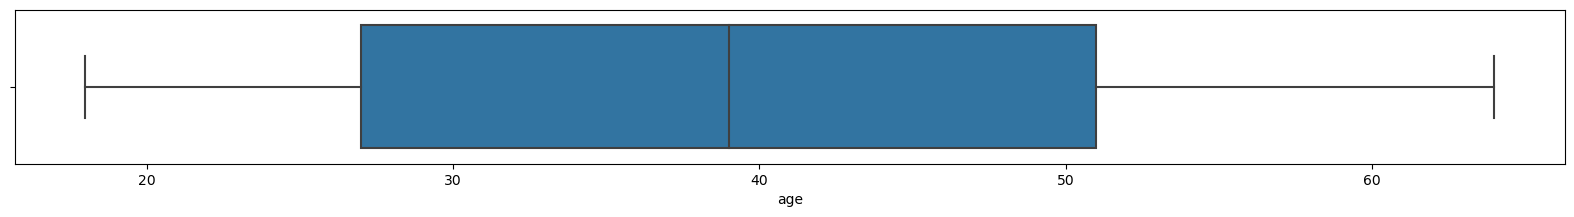

In [1313]:
# Now if we look at our age data we can see that 295 is no longer there as an outlier!
plt.figure(figsize=(20,2))
sns.boxplot(x=df['age'])
plt.show()

## Data Cleaning continued

In [1314]:
# The column for sex.
df['sex'].value_counts()
# Nothing needs to be changed here.

male      676
female    662
Name: sex, dtype: int64

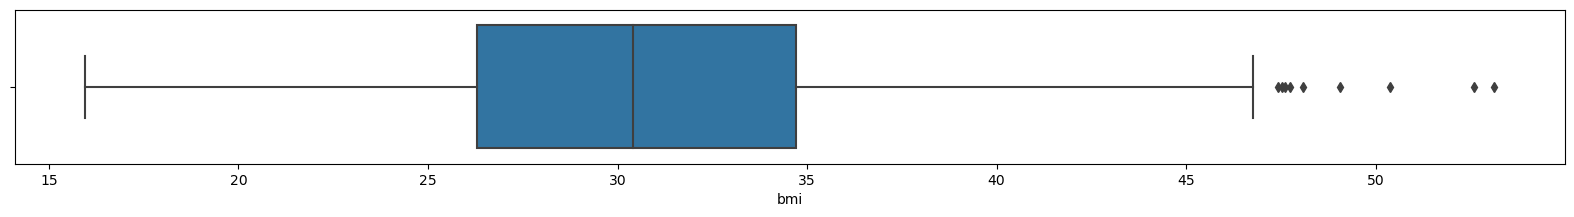

In [1315]:
# The column for bmi.
# This is continuous data so will do some EDA to look out for values that are extreme enough to be considered errors.
plt.figure(figsize=(20,2))
sns.boxplot(x=df['bmi'])
plt.show()
# There are some really high values for bmi, however these values aren't unheard of.
# Before I go ahead and decide that these data points are not the result of error, I am going to dig a little deeper.

In [1316]:
# I'm going to find out what value of bmi is the upper limit before being considered an outlier.
bmi_describe = df['bmi'].describe()
q1 = bmi_describe.loc['25%']
q3 = bmi_describe.loc['75%']
IQR = q3 - q1
max_whisk = q3 + 1.5*IQR
print(max_whisk)

47.305625000000006


In [1317]:
# These are the insured with bmi over 47.3.
df.loc[df['bmi']>max_whisk]

,broker_name,age,sex,bmi,children,smoker,region,claims_incurred
0,Broker D,18,male,53.13,0.0,no,southeast,1163.46270
1,Broker A,22,male,52.58,1.0,yes,southeast,44501.39820
2,Broker B,23,male,50.38,1.0,no,southeast,2438.05520
3,Broker A,58,male,49.06,0.0,no,southeast,11381.32540
4,Broker C,46,female,48.07,2.0,no,northeast,9432.92530
5,Broker B,52,male,47.74,1.0,no,southeast,9748.91060
6,Broker C,37,female,47.60,2.0,yes,southwest,46113.51100
7,Broker A,47,male,47.52,1.0,no,southeast,8083.91980
8,Broker C,54,female,47.41,0.0,yes,southeast,63770.42801


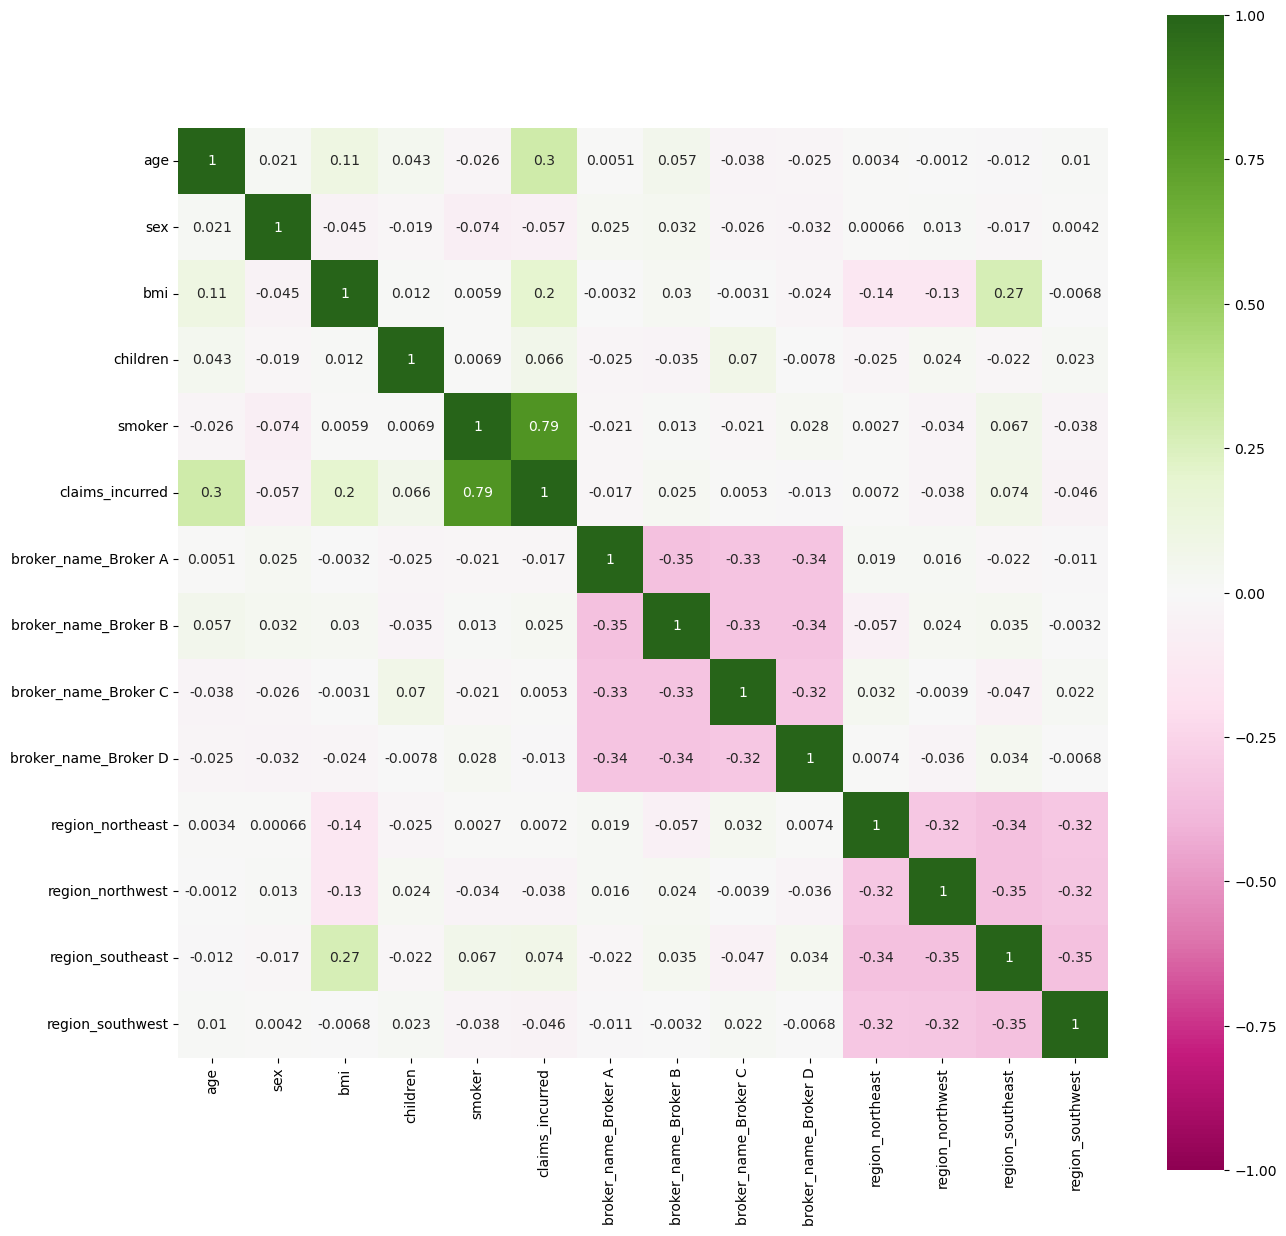

In [1318]:
# I'm going to produce a correlation heatmap to establish relationships with bmi and other columns
ohe = pd.get_dummies(df, columns = ['broker_name','region'])
ohe['sex'].replace('male',0,inplace=True)
ohe['sex'].replace('female',1,inplace=True)
ohe['sex'] = ohe['sex'].astype(bool)
ohe['smoker'].replace('no',0,inplace=True)
ohe['smoker'].replace('yes',1,inplace=True)
ohe['smoker'] = ohe['smoker'].astype(bool)
plt.figure(figsize=(15,15))
sns.heatmap(ohe.corr(), annot=True,cmap='PiYG', vmin=-1,vmax=1, center=0, square=True)
plt.show()
# I'm going to investigate bmi against age and claims incurred as there is some correlation with those columns.
# I'm going to do the same with region data as there is correlation there also.

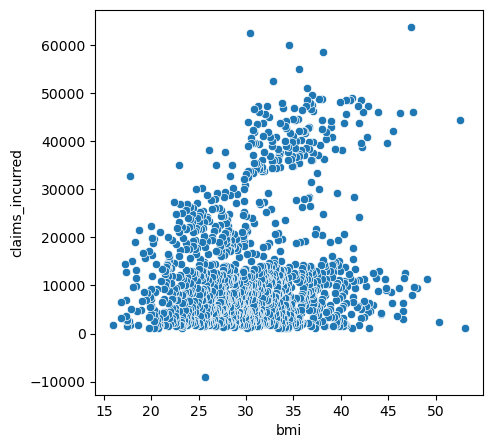

In [1319]:
# This is bmi against claims incurred. The outliers of bmi seem to be consistent with the rest of the data points.
# There are some really high claims incurred values that may be outliers themselves.
# I will investigate those when I get to it.
# I can also see a negative value for claims incurred which doesn't make any sense. This error will be fixed.
plt.figure(figsize=(5,5))
sns.scatterplot(x=df['bmi'],y=df['claims_incurred'])
plt.show()

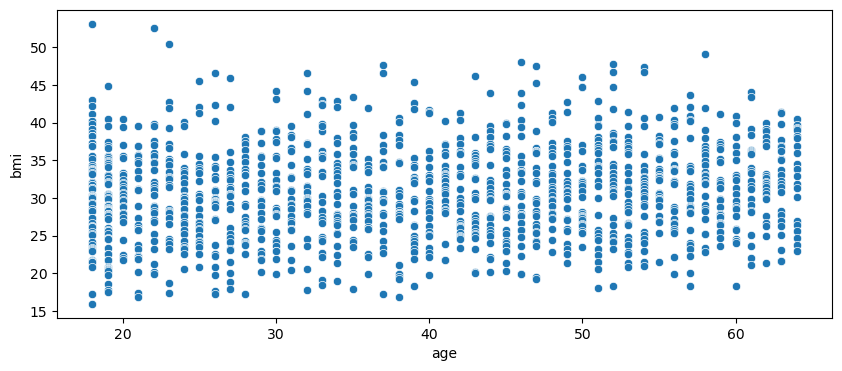

In [1320]:
# Again, even the outlier data seems to be consistent in a way that leads me to conclude no errors were made regarding bmi.
plt.figure(figsize=(10,4))
sns.scatterplot(x=df['age'],y=df['bmi'])
plt.show()

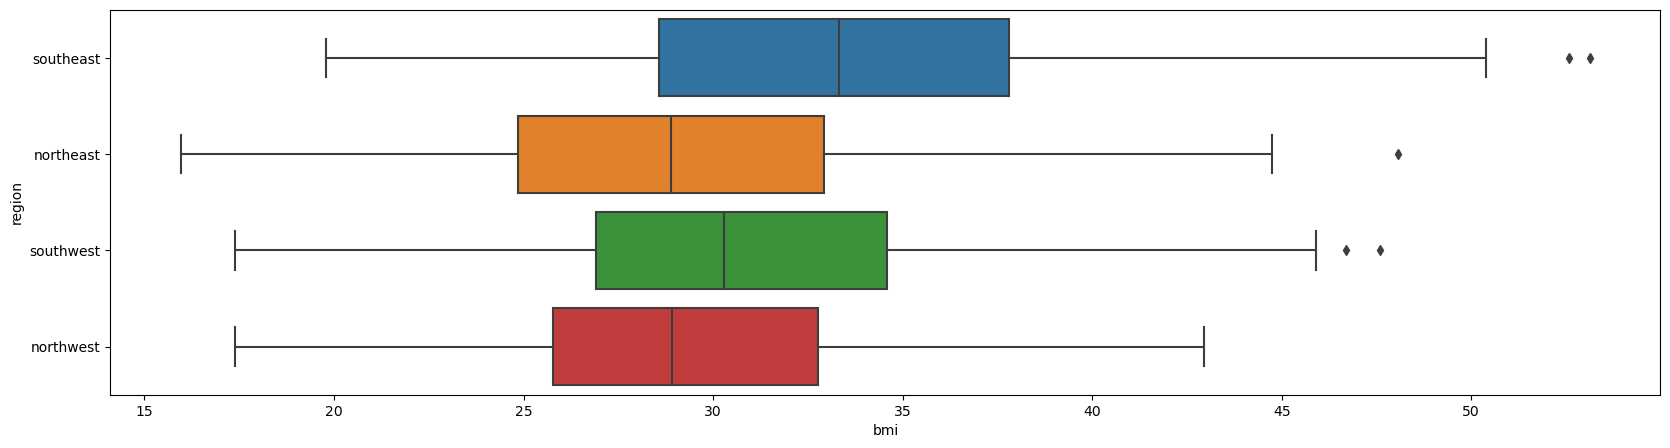

In [1321]:
# Bmi boxplots against different regions.
# The southeast seems to have a much more significantly higher bmi than the rest of the regions.
# Median bmi in the southeast is higher than q3 in both northern regions.
# The outliers on the southeast boxplot are very high compared to the other boxplots.
# However, I think they're appropriate for the southeast boxplot. Nothing has to be changed here.
plt.figure(figsize=(20,5))
sns.boxplot(x=df['bmi'],y=df['region'])
plt.show()

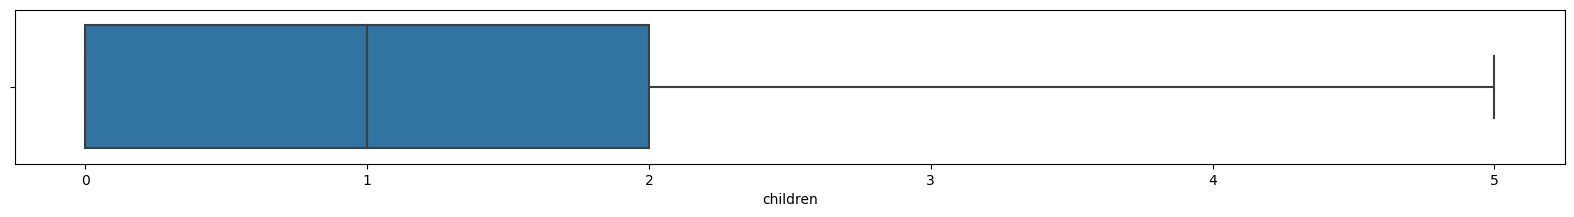

In [1322]:
# The children column.
#I'd prefer to change the datatype to integer.
df['children'] = df['children'].astype(int)

# Nothing in the distribution suggests that there may have been errors when inputting children data.
plt.figure(figsize=(20,2))
sns.boxplot(x=df['children'])
plt.show()

In [1323]:
# The smoker column.
df['smoker'].value_counts()
# I will change it to a boolean type, otherwise no cleaning is necessary.

no     1063
yes     275
Name: smoker, dtype: int64

In [1324]:
# Changing smoker to boolean type.
df['smoker'].replace('no',0,inplace=True)
df['smoker'].replace('yes',1,inplace=True)
df['smoker'] = df['smoker'].astype(bool)

In [1325]:
# The region column.
df['region'].value_counts()
# Nothing needs to be cleaned here.

southeast    364
northwest    326
southwest    325
northeast    323
Name: region, dtype: int64

In [1326]:
# Claims incurred column.
df['claims_incurred'].value_counts()
# I'm curious as to how two people have the exact same claim amount. Sheer coincidence? Let's investigate.

1639.56310     2
7281.50560     1
4415.15880     1
8232.63880     1
14001.13380    1
              ..
8538.28845     1
6128.79745     1
13462.52000    1
5594.84550     1
1694.79640     1
Name: claims_incurred, Length: 1337, dtype: int64

In [1327]:
# I am certain that this is the same person. Everything is almost identical except the broker name.
# Either there has been a mistake with data entry or this individual has seen two brokers.
# I had a look at the correlation heatmap and concluded that it is more likely this individual went with broker A.
df.loc[df['claims_incurred'] == 1639.56310]

,broker_name,age,sex,bmi,children,smoker,region,claims_incurred
648,Broker B,19,male,30.59,0,False,northwest,1639.5631
652,Broker A,19,male,30.59,0,False,northwest,1639.5631


In [1328]:
# We do not need the same information twice, so I can drop that row.
df.drop([648,648],inplace=True)
df.loc[df['claims_incurred'] == 1639.56310]

,broker_name,age,sex,bmi,children,smoker,region,claims_incurred
652,Broker A,19,male,30.59,0,False,northwest,1639.5631


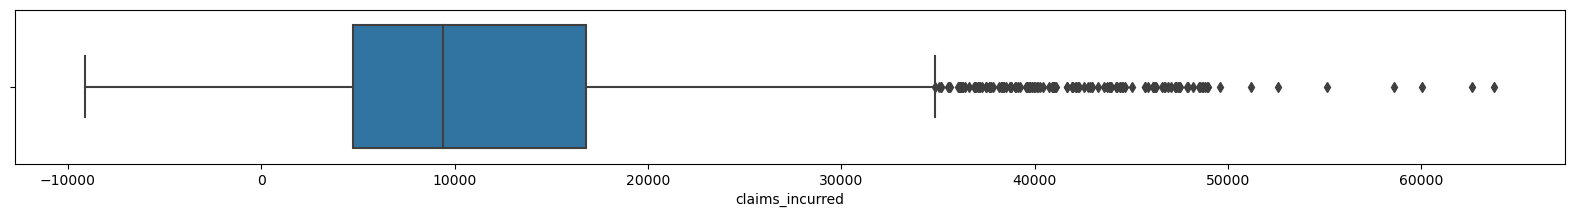

In [1329]:
# Claims incurred column.
plt.figure(figsize=(20,2))
sns.boxplot(x=df['claims_incurred'])
plt.show()
# There is a negative value that immediately needs to be fixed.
# There is also a huge cluster of outliers on the right side of the plot.
# Usually in these instances there is something hidden that we need to investigate, but firstly...

In [1330]:
# Seems that this is the only obvious mistake here.
df.sort_values(by=['claims_incurred']).head(10)

,broker_name,age,sex,bmi,children,smoker,region,claims_incurred
1050,Broker D,45,female,25.70,3,False,southwest,-9101.0000
1192,Broker B,18,male,23.21,0,False,southeast,1121.8739
691,Broker D,18,male,30.14,0,False,southeast,1131.5066
436,Broker B,18,male,33.33,0,False,southeast,1135.9407
406,Broker D,18,male,33.66,0,False,southeast,1136.3994
373,Broker A,18,male,34.10,0,False,southeast,1137.0110
346,Broker A,18,male,34.43,0,False,southeast,1137.4697
185,Broker B,18,male,37.29,0,False,southeast,1141.4451
66,Broker A,18,male,41.14,0,False,southeast,1146.7966
34,Broker D,18,male,43.01,0,False,southeast,1149.3959


## Predicting claims incurred with Machine Learning

In [1331]:
# Locate the offending row.
df.loc[1050:1050]

,broker_name,age,sex,bmi,children,smoker,region,claims_incurred
1050,Broker D,45,female,25.7,3,False,southwest,-9101.0


In [1332]:
# One hot encoding
ohe = df.copy()
ohe = pd.get_dummies(ohe, columns = ['broker_name','region'])
ohe['sex'].replace('male',0,inplace=True)
ohe['sex'].replace('female',1,inplace=True)
ohe['sex'] = ohe['sex'].astype(bool)
ohe['smoker'].replace('no',0,inplace=True)
ohe['smoker'].replace('yes',1,inplace=True)
ohe['smoker'] = ohe['smoker'].astype(bool)

In [1333]:
# Our test data.
test_data = ohe

# Separate the row from the dataframe and put it into a new variable.
test_data = test_data.loc[1050:1050]
test_data

,age,sex,bmi,children,smoker,claims_incurred,broker_name_Broker A,broker_name_Broker B,broker_name_Broker C,broker_name_Broker D,region_northeast,region_northwest,region_southeast,region_southwest
1050,45,True,25.7,3,False,-9101.0,0,0,0,1,0,0,0,1


In [1334]:
# Create a train dataframe and remove the offending row.
train_data = ohe
train_data.drop(1050,inplace=True)
train_data.loc[1050:1050]

,age,sex,bmi,children,smoker,claims_incurred,broker_name_Broker A,broker_name_Broker B,broker_name_Broker C,broker_name_Broker D,region_northeast,region_northwest,region_southeast,region_southwest


In [1335]:
# Create x_train and y_train.
x_train = train_data.drop('claims_incurred',axis=1)
y_train = train_data['claims_incurred']

In [1336]:
# Fit on x_train and y_train.
lr.fit(x_train,y_train)

LinearRegression()

In [1337]:
# Drop the claims incurred column from our testing data as it would be cheating to keep it otherwise.
x_test = test_data.drop('claims_incurred',axis=1)

In [1338]:
# Let's predict what the claims incurred should really be.
y_pred = lr.predict(x_test)
y_pred
# This prediction is pretty close in value to the positive actual value.
# It was likely an accidental input of the minus symbol.
# I will still use the ML prediction.

array([8332.09921581])

In [1339]:
# And that has been adjusted!
df['claims_incurred'].loc[1050] = 8335.29022594
df.loc[1050]

/var/folders/0m/stgl1pf9481f3my39lrjf2vc0000gq/T/ipykernel_11830/1936593069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['claims_incurred'].loc[1050] = 8335.29022594


broker_name           Broker D
age                         45
sex                     female
bmi                       25.7
children                     3
smoker                   False
region               southwest
claims_incurred    8335.290226
Name: 1050, dtype: object

In [1340]:
# Now I shall reset the index and we have a cleaned dataframe!
df.reset_index(drop=True,inplace=True)

## More EDA

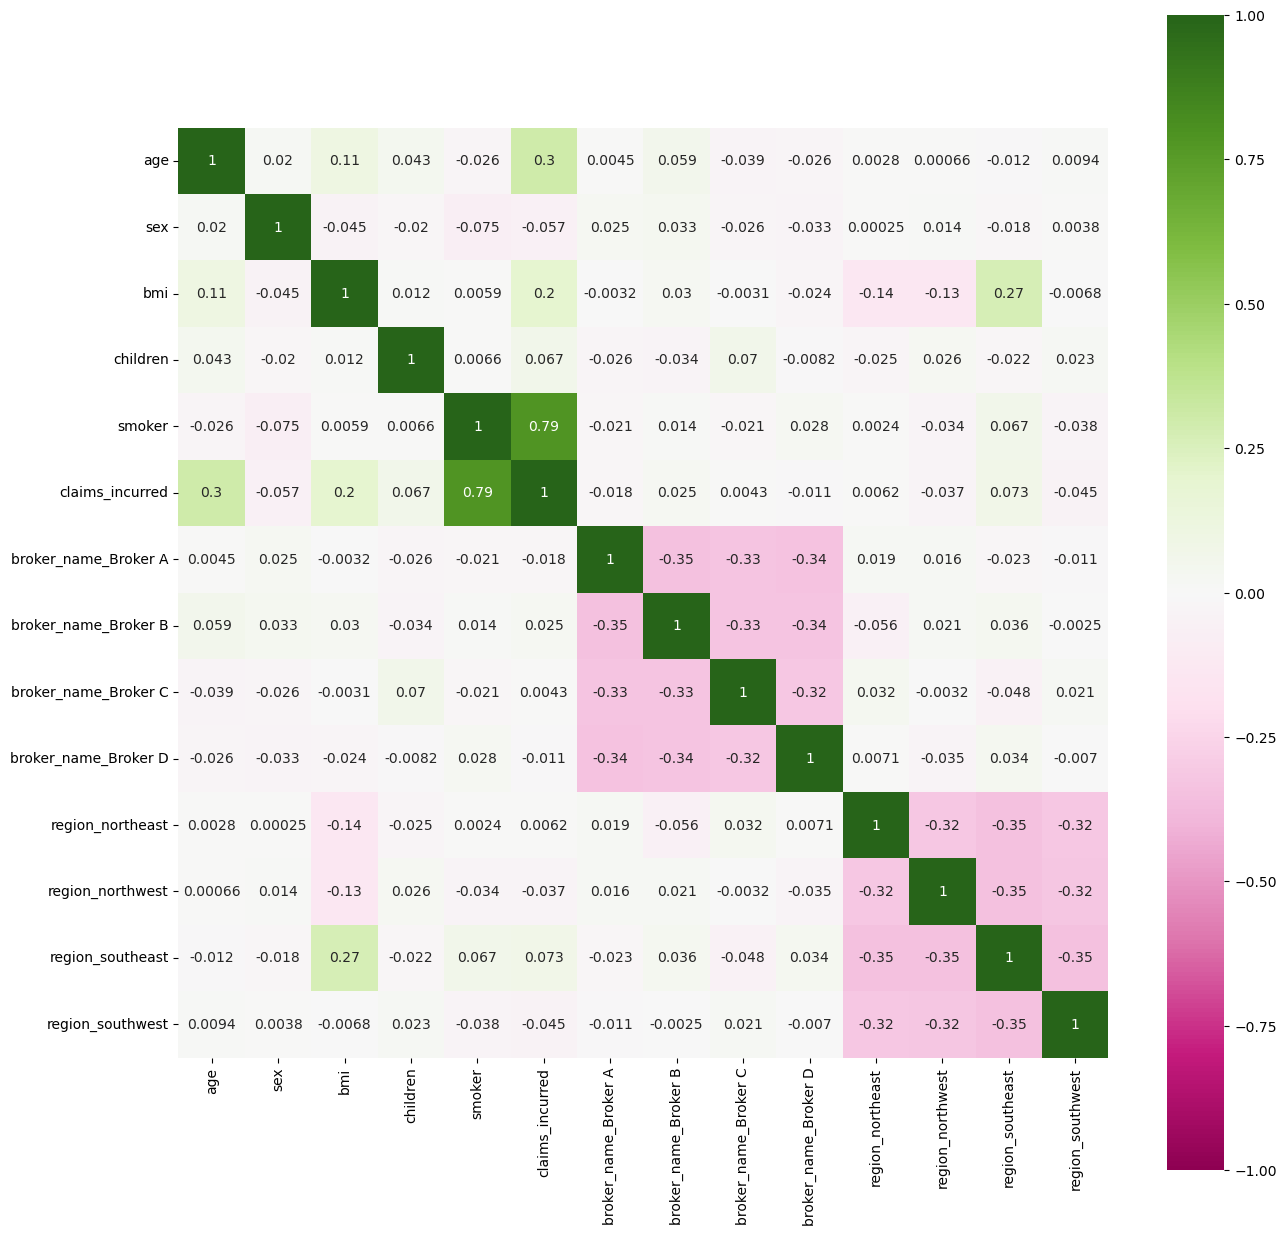

In [1341]:
# Let's bring back that large correlation heatmap.
ohe = pd.get_dummies(df, columns = ['broker_name','region'])
ohe['sex'].replace('male',0,inplace=True)
ohe['sex'].replace('female',1,inplace=True)
ohe['sex'] = ohe['sex'].astype(bool)
ohe['smoker'].replace('no',0,inplace=True)
ohe['smoker'].replace('yes',1,inplace=True)
ohe['smoker'] = ohe['smoker'].astype(bool)
plt.figure(figsize=(15,15))
sns.heatmap(ohe.corr(), annot=True,cmap='PiYG', vmin=-1,vmax=1, center=0, square=True)
plt.show()
# There is very strong positive correlation between being a smoker and claims incurred.
# There is some positive correlation between bmi and claims incurred.
# There is some positive correlation between age and claims incurred.
# There is very weak positive correlation between age and bmi.
# There are some considerable relationships between region and bmi.
# In particular, individuals from the southeast seem to be more likely to have a higher bmi.
# It is very unlikely an idividual would be with another broker, which makes me feel justified in my decision to drop that row earlier.
# It's the same case for region as well. It is unlikely that an individual is living in multiple places.
# Anything else is very weakly related.

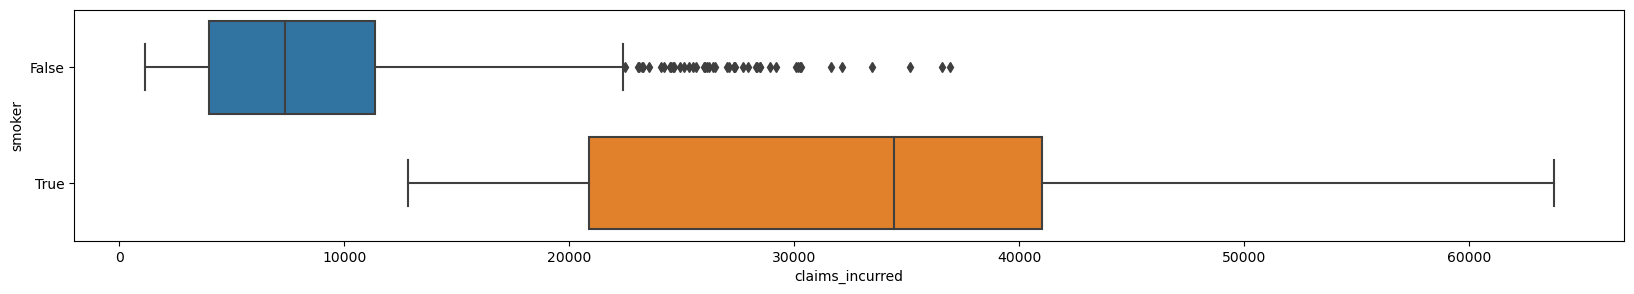

In [1342]:
# Boxplots looking at claims incurred distribution, separated by smoker status.
# There are only outliers after the right whisker of the non-smoker boxplot, and there are loads!
# These outliers also sit snuggly within the IQR of the smokers boxplot.
# A possible explanation is the likelihood that some of the insured didn't accurately declare their smoker status.
# There may be plenty of insured that are actually smokers but have stated that they are non-smokers.
plt.figure(figsize=(20,3))
sns.boxplot(x=df['claims_incurred'],y=df['smoker'].astype(str))
plt.show()

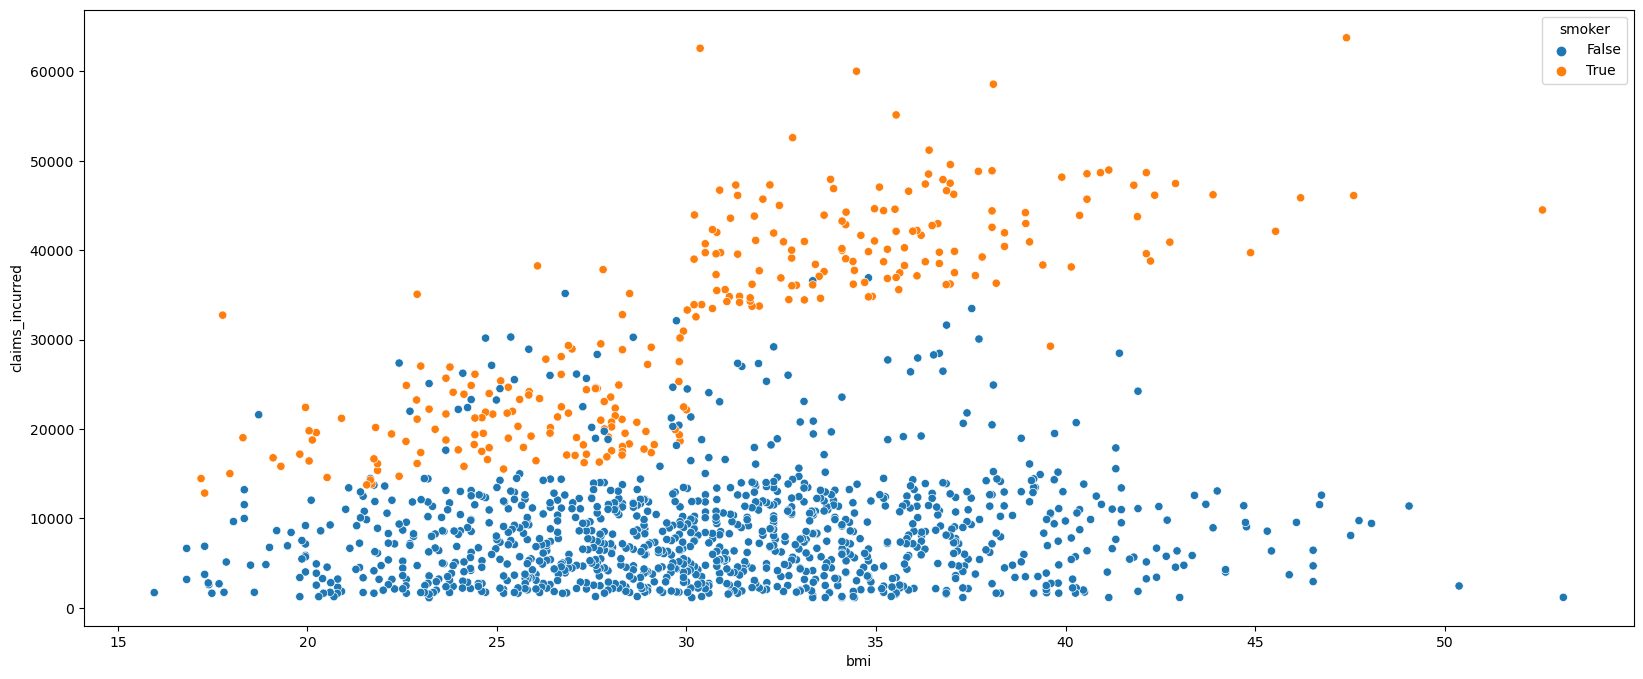

In [1343]:
# Scatterplot of bmi against claims incurred, separated by hue on smoker status.
# There is a huge cluster of non-smokers at the lower end of the claims incurred, and of all bmi ranges.
# Smokers have higher claims incurred than non-smokers. There are two clusters of smokers. 
# Smokers with bmi over 30 has significantly higher claims incurred than smokers with bmi under 30.
# Bmi of 30 and above is considered obesity, and would come with significant higher health risks.
# This may explain the sudden jump in claims incurred.
# There are small groups of"non-smokers" hidden within the smoker clusters, which may relate to my assumption from the previous boxplots.
plt.figure(figsize=(20,8))
sns.scatterplot(x=df['bmi'],y=df['claims_incurred'],hue=df['smoker'])
plt.show()

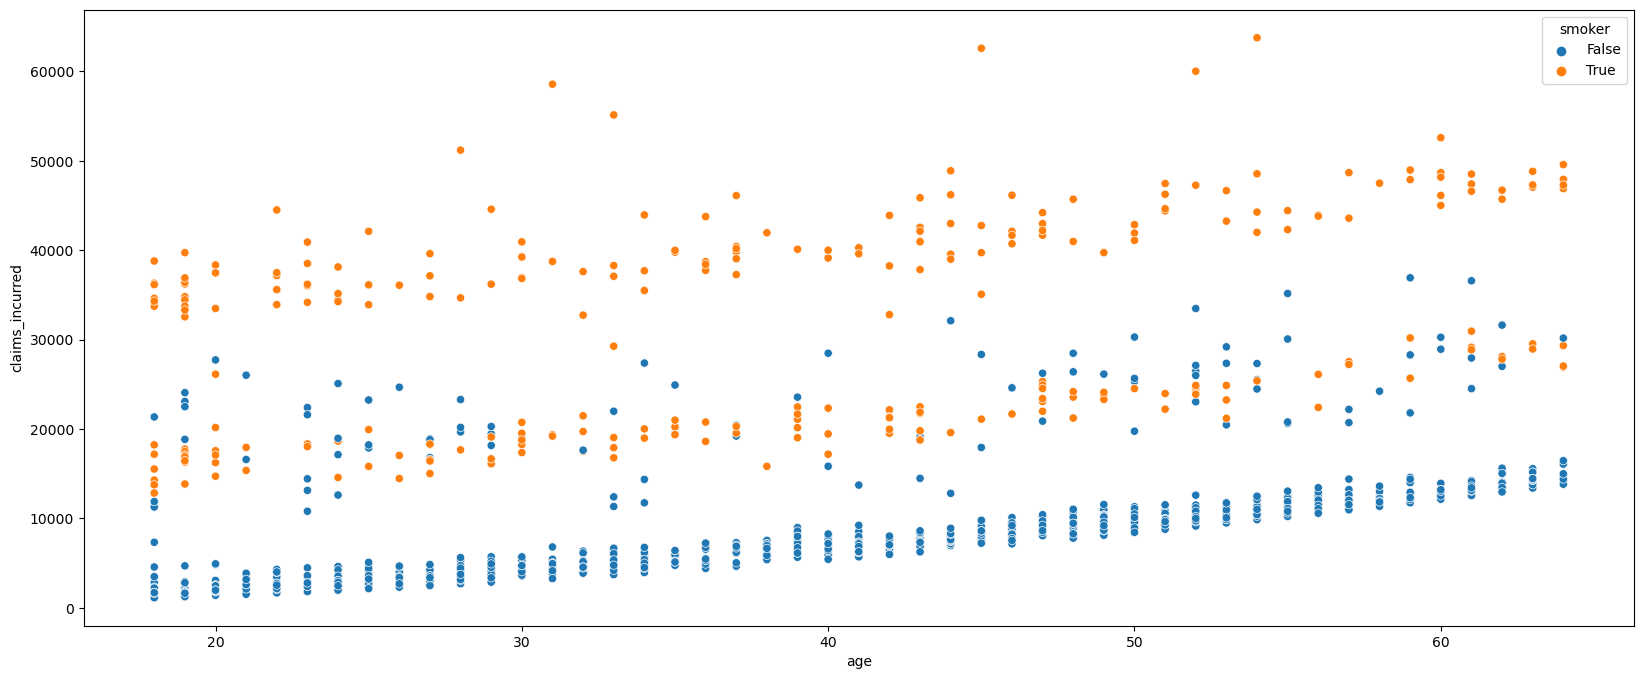

In [1355]:
# Scatterplot of age against claims incurred, separated by hue on smoker status.
# There are 3 separate clusters. They all increase in claims incurred as age increases.
# This would make sense, as people age they become more susceptible to accidents/illness and the risk of making health related claims increases.
# The bottom cluster is entirely non-smokers of all ages. This cluster has the lowest claims incurred.
# The top cluster is entirely smokers of all ages. This cluster has the highest claims incurred.
# The middle cluster is mostly smokers with a mix of non-smokers of all ages.
# Claims incurred for this cluster falls in the middle.
# While the difference between the top and bottom clusters is obvious, we don't have an explanation for the mixed middle cluster.
# So what makes the middle cluster different to the top and bottom clusters?
plt.figure(figsize=(20,8))
sns.scatterplot(x=df['age'],y=df['claims_incurred'], hue=df['smoker'])
plt.show()

<Figure size 2000x500 with 0 Axes>

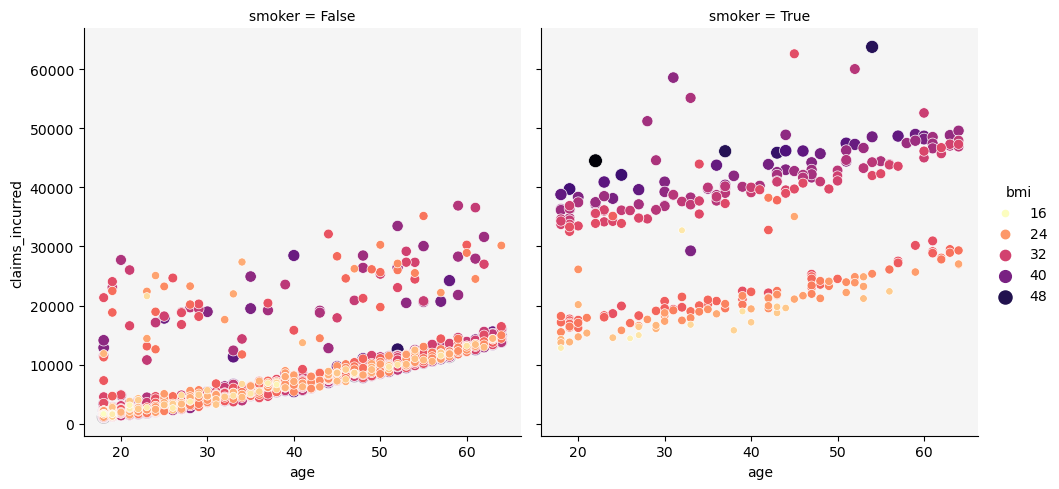

In [1380]:
# We have revealed 4 clusters!
# Smokers with high bmi.
# Smokers with normal bmi.
# Non-smokers with normal bmi.
# Non-smokers with high bmi.
# There are also your occasional data points that are likely a result of exceptional circumstances i.e. In the case of a severe accident and life changing injury.
# Smokers with high bmi have the highest claims incurred.
# Non-smokers with low bmi have the lowest claims incurred.
# Smokers at normal bmi and non-smokers with high bmi seem to have similar average cost of claims, although high bmi non-smokers have more variance in their costs.
# Smokers at normal bmi would be more predictable in their claims that non-smokers with high bmi.
# Non-smokers with high bmi may have greater risk of having higher claim costs than smokers with normal bmi.
plt.figure(figsize=(20,5))
min_size = 20
max_size = 100
plt.rcParams['axes.facecolor'] = 'whitesmoke'
sns.relplot(x=df['age'],y=df['claims_incurred'],col=df['smoker'], size=df['bmi'],kind='scatter', sizes=(min_size,max_size), hue=df['bmi'],palette='magma_r')
plt.show()

<Figure size 2000x500 with 0 Axes>

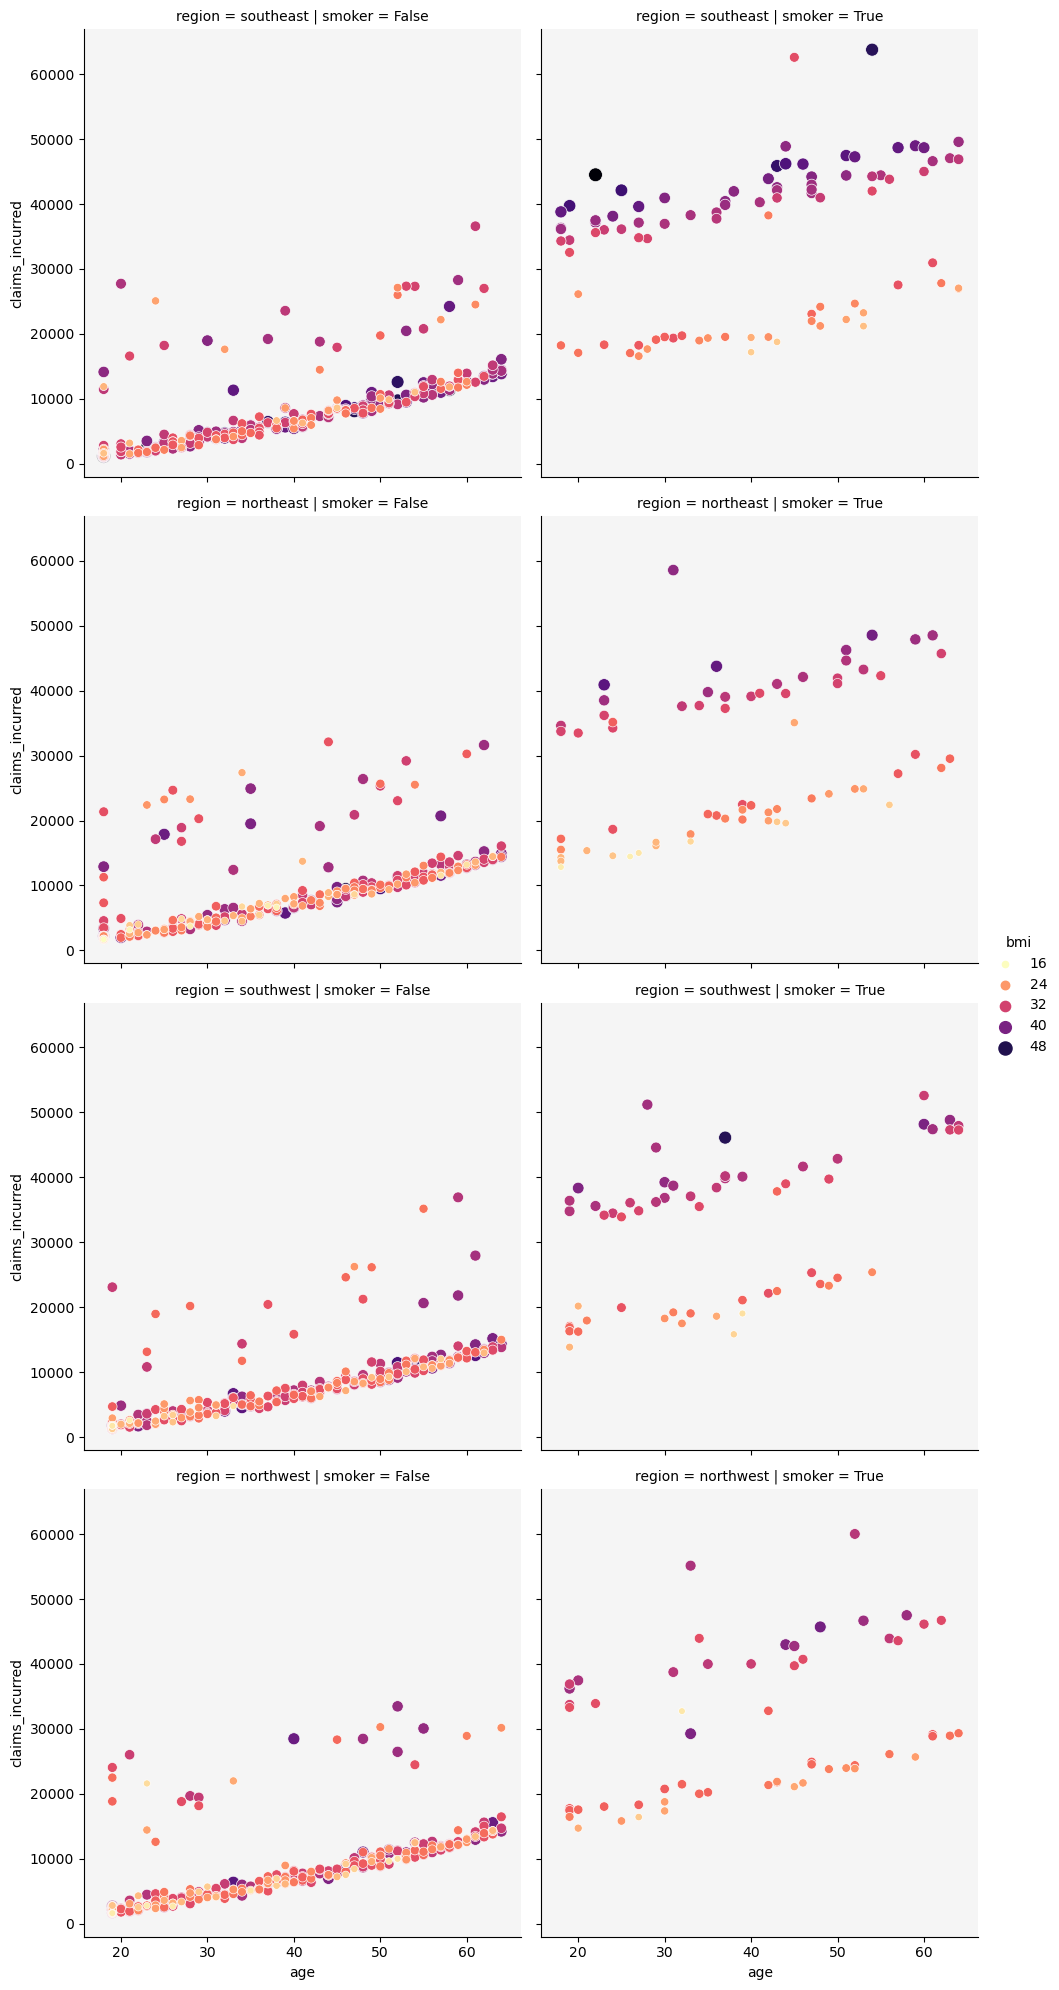

In [1381]:
# Before I wrap things up I would like to look at the impact of region as that had some noticable influence on bmi.
# The only obvious thing here is that those from the southeast region tend to have higher bmi than the other regions and are more likely to be smokers.
# There is some evidence that individuals from the southeast are likely to have higher claims incurred, however...
# This is indirectly through the fact that there is more of a prevalence of smokers and people with high bmi.
# There are still plenty of individuals from the southeast that have low claims incurred and are non-smokers/normal bmi.
# Just the same as the other regions. I don't think region is a strong indicator of cost of claims in an individual.
plt.figure(figsize=(20,5))
min_size = 20
max_size = 100
plt.rcParams['axes.facecolor'] = 'whitesmoke'
sns.relplot(x=df['age'],y=df['claims_incurred'],col=df['smoker'],row=df['region'], size=df['bmi'],kind='scatter', sizes=(min_size,max_size), hue=df['bmi'],palette='magma_r')
plt.show()

## Conclusions

* The biggest factors of the total cost of claims incurred by an insured are __smoking status__ and __bmi score__. __Age__ is also a factor; it does not have as much influence as the former columns, however there is still some significant influence that it should be considered. It is a positive relationship, meaning that as these factors increase in quantity/prevalence, the higher the total cost of claims will be.
* Individuals from the southeast are more likely to see an increase in these qualities compared to other regions. However, evaluating a policy based on this factor is unnecessary as we can already have access to the other factors that will be specfic to the individual.
* A high bmi is defined as a score over 30. This is consistent with the bmi score that is considered obesity.
* Insured can be broken into 4 clusters. In order from lowest risk to highest; non-smokers with normal bmi, smokers with normal bmi, non-smokers with high bmi, and smokers with high bmi. Non-smokers with high bmi and smokers with normal bmi have similar average costs incurred, however there is more variation in those with high bmi, making their risk more unpredictable. Based on this analysis, the lowest risk insured would be a fit non-smoker in their early 20's. The highest risk insured would be someone elderly that smokes and has high bmi. 
* Based on the distribution of claims incurred, there are potentially some insured that have incorrectly declared themselves to be non-smokers. Where these individuals claim costs begin to fall within the ranges of smoker data, I would advise reviewing their policy, investigate the cause of their high costs and possibly requesting medical evidence that they are non-smokers. Increasing their premiums may be advised if the customer is consistently making claims.